In [4]:
################################################################################
# CS 224W (Fall 2017) - HW2
# Code for Problem 3.1
# Author: luis0@stanford.edu
# Last Updated: Oct 26, 2017
################################################################################

import os

import snap
import random
import matplotlib.pyplot as plt


from enum import Enum
from collections import Counter

In [5]:
VoterState = Enum('VoterState', 'UNDECIDED VOTEA VOTEB')
    
def removeSelfEdges(G):
    for edge in G.Edges():
        u, v = edge.GetId()
        if u == v:
            G.DelEdge(u,v)
    return G

In [6]:
def assignInitialVotes(G):
    '''
    Assigns the initial voting configuration to each node in G and returns
    a map for every node to VoterState. Also returns a list of nodeIds that
    are undecided.
    '''
    state = {}
    undecided = []
    for node in G.Nodes():
        lastDigit = node.GetId() % 10
        if lastDigit in [0,1,2,3]:
            state[node.GetId()] = VoterState.VOTEA
        elif lastDigit in [4,5,6,7]:
            state[node.GetId()] = VoterState.VOTEB
        else:
            state[node.GetId()] = VoterState.UNDECIDED
            undecided.append(node.GetId())
    return (state, undecided)
 

In [7]:
def loadGraphs(filenames):
    '''
    Loads the graphs and return a map specifying each voters
    current state.
    
    returns: [(Graph, State, Undecided)] - list of tuple of graph, 
    dictionary mapping nodeIds to their current VoterState, and list
    of undecided nodeIds for each graph loaded.
    '''
    result = []
    for filename in filenames:
        G = removeSelfEdges(
            snap.LoadEdgeList(snap.PUNGraph, filename, 0, 1))
        votes, undecided = assignInitialVotes(G)
        result.append((G, votes, undecided))
    return result

In [8]:
def getVote(node, votes):
    '''
    Determine the voting state of snap.NodeI based on current votes of all
    other nodes.
    
    return: VoterState for node.
    '''
    global defaultVote
    voteA = 0 
    voteB = 0
    counts = Counter([votes[node.GetNbrNId(i)] for i in xrange(node.GetDeg())])
    
    myVote = VoterState.UNDECIDED
    if counts[VoterState.VOTEA] > counts[VoterState.VOTEB]:
        myVote = VoterState.VOTEA
    elif counts[VoterState.VOTEA] < counts[VoterState.VOTEB]:
        myVote = VoterState.VOTEB
    else:
        myVote = defaultVote
        defaultVote = (VoterState.VOTEB
                       if defaultVote == VoterState.VOTEA
                       else VoterState.VOTEA)
    assert myVote != VoterState.UNDECIDED
    return myVote

In [9]:
def runProcessOnGraph(G, votes, undecidedList):
    '''
    Performs the process descdribed in 3.1 for one iteration.
    undecidedList must already be sorted.
    
    return: all values modified in place (except undecidedList).
    '''
    for nodeId in undecidedList:
        votes[nodeId] = getVote(G.GetNI(nodeId), votes)

In [10]:
def runProcess(graphData, numIters=10):
    '''
    returns a list of results for each graph. Each result is a tuple
    of the winner and the # of votes the election was won by.
    '''
    global defaultVote
    defaultVote = VoterState.VOTEA
    results = []
    for G, votes, undecided in graphData:
        for _ in xrange(numIters):
            runProcessOnGraph(G, votes, undecided)
            voteCount = Counter(votes.values())
            assert voteCount[VoterState.UNDECIDED] == 0
        results.append(("A"
            if voteCount[VoterState.VOTEA] > voteCount[VoterState.VOTEB]
            else "B" if voteCount[VoterState.VOTEA] <  voteCount[VoterState.VOTEB]
            else "UNDECIDED",
            abs(voteCount[VoterState.VOTEA] - voteCount[VoterState.VOTEB])
        ))
    return results

In [11]:
def Q3_1():
    NUM_DAYS = 10
    filenames = ['data/graph%s.txt' % (i + 1) for i in xrange(2)]
    graphData = loadGraphs(filenames)
    results = runProcess(graphData, NUM_DAYS)
    for i, (winner, voteDiff) in enumerate(results):
        print("Candidate %s wins by %s votes in Graph %s." % (
            winner, voteDiff, i + 1))

In [12]:
Q3_1()

Candidate B wins by 76 votes in Graph 1.
Candidate B wins by 350 votes in Graph 2.


In [13]:
def Q3_2():
    NUM_DAYS = 10
    filenames = ['data/graph%s.txt' % (i + 1) for i in xrange(2)]
    X = range(0, 9001, 1000)
    Ys = [[] for _ in filenames]
    for k in X:
        # load the default graph configuration.
        graphData = loadGraphs(filenames)
        affectedVoters = xrange(3000, 3000 + k / 100)
        # Spend your advertising money! Always spend *some* amount.
        for i in xrange(len(graphData)):
            G, votes, undecided = graphData[i]
            removed = 0
            for affectedVoter in affectedVoters:
                if votes[affectedVoter] == VoterState.UNDECIDED:
                    removed += 1
                votes[affectedVoter] = VoterState.VOTEA
            newUndecided = [nodeId for nodeId in votes
                             if votes[nodeId] == VoterState.UNDECIDED]
            assert len(newUndecided) == len(undecided) - removed
            graphData[i] = (G, votes, newUndecided)
        results = runProcess(graphData, NUM_DAYS)
        assert len(results) == len(Ys)
        for i, (winner, margin) in enumerate(results):
            assert winner == "A" or winner == "B"
            Ys[i].append(margin if winner == "A" else -margin)
    plt.close()
    for Y in Ys:
        plt.plot(X,Y)
    plt.legend(["Graph%s" % (i + 1)
                for i in xrange(len(Ys))], loc='upper left')
    plt.xlabel("Amount Spent in Advertising ($)")
    plt.ylabel("Margin of Victory for A")
    plt.title("Margin of Victory as AdSpend on A")
    if not os.path.isdir("output"):
        os.makedirs("output")
    plt.savefig("output/3_2_plot", dpi=600)
    plt.show()
    
    minimums = []
    for Y in Ys:
        for i, y in enumerate(Y):
            if y > 0:
                assert i + 1 < len(Y)
                minimums.append((X[i], Y[i+1]))
                break
    for i, (spend, margin) in enumerate(minimums):
        print("We can spend about $%s (based on our experiments) "
              "and win the election on Graph %s in favor of A "
              "by %s votes." % (spend, i + 1, margin))
                

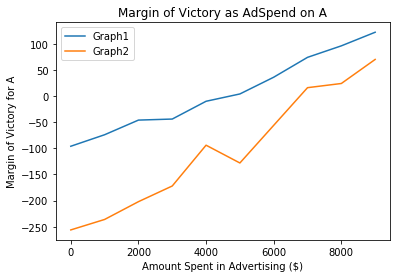

We can spend about $5000 (based on our experiments) and win the election on Graph 1 in favor of A by 36 votes.
We can spend about $7000 (based on our experiments) and win the election on Graph 2 in favor of A by 24 votes.


In [14]:
Q3_2()

In [15]:
def getSortedHighRollers(G):
    '''
    Returns sorted tuples of (nodeDegree, nodeID)
    '''
    nodeinfo = [(node.GetDeg(), node.GetId()) for node in G.Nodes()]
    return sorted(nodeinfo, key = lambda x: (-x[0], x[1]))

In [16]:
def Q3_3():
    NUM_DAYS = 10
    filenames = ['data/graph%s.txt' % (i + 1) for i in xrange(2)]
    X = range(0, 9001, 1000)
    Ys = [[] for _ in filenames]
    # Get all highrollers for each graph.
    Graphs = loadGraphs(filenames)
    highRollers = []
    for Graph, _, _ in Graphs:
        highRollers.append(getSortedHighRollers(Graph))
    
    for k in X:
        # load the default graph configuration.
        graphData = loadGraphs(filenames)
        # Spend your advertising money! Always spend *some* amount.
        for i in xrange(len(graphData)):
            G, votes, undecided = graphData[i]
            removed = 0
            affectedVoters = [nodeID
                              for _, nodeID in highRollers[i][:k / 1000]]
            for affectedVoter in affectedVoters:
                if votes[affectedVoter] == VoterState.UNDECIDED:
                    removed += 1
                votes[affectedVoter] = VoterState.VOTEA
            newUndecided = [nodeId for nodeId in votes
                             if votes[nodeId] == VoterState.UNDECIDED]
            assert len(newUndecided) == len(undecided) - removed
            graphData[i] = (G, votes, newUndecided)
        results = runProcess(graphData, NUM_DAYS)
        assert len(results) == len(Ys)
        for i, (winner, margin) in enumerate(results):
            assert winner == "A" or winner == "B"
            Ys[i].append(margin if winner == "A" else -margin)
    plt.close()
    for Y in Ys:
        plt.plot(X,Y)
    plt.legend(["Graph%s" % (i + 1)
                for i in xrange(len(Ys))], loc='upper left')
    plt.xlabel("Amount Spent Dining High Rollers ($)")
    plt.ylabel("Margin of Victory for A")
    plt.title("Margin of Victory as $ Spent dining High Rollers")
    if not os.path.isdir("output"):
        os.makedirs("output")
    plt.savefig("output/3_3_plot", dpi=600)
    plt.show()
    
    minimums = []
    for Y in Ys:
        appended = False
        for i, y in enumerate(Y):
            if y > 0:
                assert i + 1 < len(Y)
                minimums.append((X[i], Y[i+1]))
                appended = True
                break
        if not appended:
            minimums.append((None, None))
    for i, (spend, margin) in enumerate(minimums):
        print("We can spend $%s and win the election on Graph "
              "%s in favor of A by %s votes." % (spend, i + 1, margin))

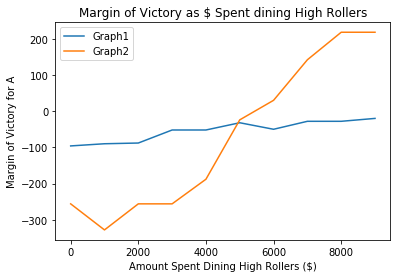

We can spend $None and win the election on Graph 1 in favor of A by None votes.
We can spend $6000 and win the election on Graph 2 in favor of A by 142 votes.


In [17]:
Q3_3()

In [18]:
def getDataPointsToPlot(Graph):
    """
    :param - Graph: snap.PUNGraph object representing an undirected graph
    
    return values:
    X: list of degrees
    Y: list of frequencies: Y[i] = fraction of nodes with degree X[i]
    """
    degreeDistribution = snap.TIntPrV()
    snap.GetDegCnt(Graph, degreeDistribution)
    N = float(Graph.GetNodes())
    X, Y = [], []
    for item in degreeDistribution:
        X.append(item.GetVal1())
        Y.append(float(item.GetVal2()) / N)
    return X, Y

In [21]:
def Q3_4():
    filenames = ['data/graph%s.txt' % (i + 1) for i in xrange(2)]
    graphData = loadGraphs(filenames)
    
    plt.close()
    for G, _, _ in graphData:
        X,Y = getDataPointsToPlot(G)
        plt.loglog(X, Y)
        
    plt.xlabel('Node Degree (log)')
    plt.ylabel('Proportion of Nodes with a Given Degree (log)')
    plt.title('Degree Distribution of Graph 1 and Graph 2')
    plt.legend(["Graph%s" % (i + 1)
                for i in xrange(len(graphData))], loc='upper left')
    plt.savefig("output/3_4_plot", dpi=600)
    plt.show()

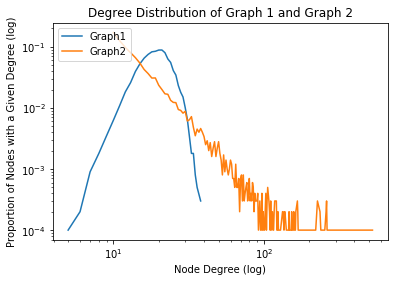

In [22]:
Q3_4()